# RV curves of eccentric exoplanets

Figure 5.3 from Chapter 5 of Ryden, *Celestial and Stellar Dynamics*, Cambridge University Press.

Radial velocity curves of two exoplanets with very eccentric orbits with different orientations of the
line of periapse relative to the line of sight ($\omega$)
 * HD 20868, e=0.75, $\omega=365.2$ deg - Moutou et al. [2009, A&A, 496, 513](https://ui.adsabs.harvard.edu/abs/2009A%2526A...496..513M)
 * HD 181234, e=0.73, $\omega=93.3$ deg - Rickman et al. [2019, A&A, 625, 71](https://ui.adsabs.harvard.edu/abs/2019A%2526A...625A..71R)

Phase both RV curves to the epoch of periapse (T$_p$), and compute and plot the best-fit RV curve that
runs through the data points using the best-fit orbit parameters given in each of the two papers.

The stars were chosen to have a similar eccentricity ($\sim$0.75) but with the line of apsides oriented
perpendicular to the line of sight ($\omega\sim0^\circ$) and along the line of sight ($\omega\sim90^\circ$). 

In [10]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# used for Newton-Raphson root solver for Kepler's equation

from scipy.optimize import newton

# supress nuissance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)
warnings.filterwarnings('ignore',category=RuntimeWarning, append=True)

## Standard Plot Format

Setup the standard plotting format and make the plot.  

In [11]:
plotFile = 'Fig5_3.png' 

# graphic aspect ratio = width/height

aspect = 4.0/3.0

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 0.85

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 8
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## Orbit calculations

For an eccentric orbit, the radial velocity, $K(t)$, is
\begin{equation}
  K(t) = K_\star\left[\cos(\theta(t))+\omega + e\cos(\omega)\right]
\end{equation}
where
 * $K_\star$ is the radial velocity semi-amplitude
 * $e$ is the orbit eccentricty
 * $\omega$ is the argument of periapse

and $\theta$ is the angle relative to the line of sight:
\begin{equation}
 \theta(t) = 2\arctan\left[\left(\frac{1+e}{1-e}\right)^{1/2}\tan\left(\frac{E(t)}{2}\right)\right]
\end{equation}
where $E(t)$ is the eccentric anomaly, found by solving Kepler's equation.

### Mean anomaly, $M$

The mean anomaly $M$ is 
\begin{equation}
 M(t) = \frac{2\pi}{P}\left(t-T_p\right)
\end{equation}

### Eccentric anomaly, $E$

where $T_p$ is the epoch of periapse.  The mean anomaly $M$ is related to the eccentric anomaly $E$ and
eccentricity $e$ by Kepler's equation:
 > $M = E - e\sin(E)$

Kepler's equation cannot be solved analytially to compute $E$ given $M$ and $e$ from the orbit elements, so
we solve it numerically using the Newton-Raphson method.  

Define a function $f(E)$
 > $f(E) = E - e\sin(E) - M$

with derivative
 > $\frac{dfE}{dE} = 1 - e\cos(E)$

And solve for $f(E)=0$ given $M$ and $e$.  We will use the `scipy.optimize.newton()` function to solve
for the roots using the Newton-Raphson method.

### True anomaly, $\nu$

Compute the true anomaly $\nu$ given the eccentric anomaly $E$ and orbit eccentricity $e$, using a form that
is numerically safe when E is near $\pm\pi$:
\begin{equation}
  \nu = E + 2\arctan\left(\frac{\beta\sin E}{1-\beta\cos E}\right)
\end{equation}
where
\begin{equation}
  \beta = \frac{e}{1+(1-e^2)^{1/2}}
\end{equation}

In [12]:
# Kepler's equation - assumes M and E in radians

def kepler(E,M,e):
    return (E - e*np.sin(E) - M)

# Derivative of Kepler's equation, E in radians

def kepler_deriv(E,M,e):
    return (1.0 - e*np.cos(E))

# Compute the eccentric anomaly - M must be in radians

def eccAnomaly(M,e):
    E = newton(kepler, M, kepler_deriv, args=(M,e))
    return E

# Compute the true anomaly - E must be in radians

def trueAnomaly(E,e):
    beta = e/(1.0+np.sqrt(1-e*e))
    sin_nu = beta*np.sin(E)
    cos_nu = 1 - beta*np.cos(E)
    nu = E + 2.0*np.arctan2(sin_nu,cos_nu)
    return nu

## RV data

For each star we phase-fold the RV curves using the epoch of periapse (T$_p$) and the orbital period (P).

To plot the best-fit orbit RV curve, we use Equation 5.20 in the book:
 > $v_r (t) = v_{r,0} + K \left[\cos(\nu(t) + \omega_\ell) + e\cos\omega_\ell\right]$

We solve Kepler's equation using a Newton-Raphson root solver to compute $\nu(t)$ using the best-fit orbit
parameters provided in both papers.

### HD 20868

HARPS data for HD 20868 from Moutou et al. 2009, A&A, 496, 513, see Figure 2

Three data columns:
 * JD = Julian day number
 * RV = radial velocity in km/s including the systemtic velocity of the system
 * e_RV = error on the radial velocity in km/s
 
Best-fit orbit parameters from Table 2:
 * $P$ = 380.85 days
 * $K_\star$ = 100.34 m/s
 * $e$ = 0.75
 * $\omega_\ell$ = 356.2 degrees
 * $T_p$ = 54451.52 (JD-2400000 days) - epoch of periastron
 * $\gamma$ = -46.245 km/s - RV offset (same as $v_{r,0}$ above)
 

In [13]:
rvFile = 'RVs/HD20868_Moutou2009.txt' 

data = pd.read_csv(rvFile,sep=r'\s+',comment='#')

JD1 = np.array(data['JD']) - 2400000. # convert to JD-2400000
rawRV = 1000*np.array(data['RV']) # convert to m/s
eRV1 = 1000*np.array(data['e_RV']) # convert to m/s

# correct all RVs to the exoplanet barycenter

gamma = -46245 # m/s

RV1 = rawRV + gamma

# orbit parameters

P = 380.85 # days
Kstar = 100.34 # m/s
e = 0.75
w = 356.2 # degrees
Tp = 54451.52

# phase fold on period and epoch of periastron

rawPhase = (JD1 - Tp)/P
phase1 = rawPhase - np.floor(rawPhase)

# compute the mean anomaly for the best-fit orbit

fitPhase1 = np.linspace(-0.2,1.2,1001)
M = 2*np.pi*fitPhase1

# solve for the eccentric and true anomaly for the orbit points

E = eccAnomaly(M,e)
nu = trueAnomaly(E,e)

# best fit RV curve

fitRV1 = Kstar * (np.cos(nu + np.radians(w)) + e*np.cos(np.radians(w)))

# phase limits

pMin = -0.175
pMax = 1.175

# RV limits

rvMin1 = -40.0 # m/s
rvMax1 = 199.0 

### HD 181234

CORALIE data for HD 181234 from Rickman et al. 2019, A&A, 625, 71, see Figure 1

Three data columns:
 * RJD = Julian day number, JD - 2400000
 * RV = radial velocity in m/s including the systemtic velocity of the system
 * e_RV = error on the radial velocity in m/s
 
Best-fit orbit parameters are (Tables 3 and B.1):
 * $P$ = 20.43 yr
 * $K_\star$ = 126.8 m/s
 * $e$ = 0.73 +/- 0.01
 * $\omega_\ell$ = 93.3 +/- 1.7 degrees
 * $T_p$ = 7668.7 days - epoch of periastron
 * $\gamma$ = 46663.21 m/s - RV offset
 
There are different TV offsets for the 3 CORALIE campaigns. We implement these relative to the
CORALIE07 campaign:
 * CORALIE98 = 5.41 m/s, BJD-2450000 < 4100
 * CORALIE14 = -14.32 m/s, BJD-2450000 > 7000
 
following the description in Rickman et al.

In [14]:
rvFile = 'RVs/HD181234_Rickman2019.txt' 

data = pd.read_csv(rvFile,sep=r'\s+',comment='#')

RJD = np.array(data['RJD'])
rawRV = np.array(data['RV'])
eRV2 = np.array(data['e_RV'])

JD2 = RJD - 50000

# correct RV to exoplanet barycenter - depends

gamma = 46663.21 # m/s - CORALIE07 applied to all
RV2 = rawRV + gamma

RV2[np.where(JD2 <= 4100)] += 5.41   # CORALIE98 - CORALIE07
RV2[np.where(JD2 >= 7000)] += -14.32 # CORALIE14 - CORALIE07

# orbit parameters

P = 20.43*365.25 # days
Kstar = 126.8 # m/s
e = 0.73
w = 93.3 # degrees
Tp = 7668.7
gammaRV = 0.0 # -5.41 # 14.32

# phase fold on period and epoch of periastron

rawPhase = (JD2 - Tp)/P
phase2 = rawPhase - np.floor(rawPhase)

# compute the mean anomaly for the best-fit orbit

fitPhase2 = np.linspace(-0.2,1.2,1001)
M = 2*np.pi*fitPhase2

# solve for the eccentric and true anomaly for the best-fit orbit

E = eccAnomaly(M,e)
nu = trueAnomaly(E,e)

# best-fit RV curve

fitRV2 = gammaRV + Kstar*(np.cos(nu + np.radians(w)) + e*np.cos(np.radians(w)))

# RV limits

rvMin2 = -180.0 # m/s
rvMax2 = 149.0

## Figure 5.3 

Plot the phase-folded RV curves for HD 20868 (top) and HD 181234 (bottom) as a 2-panel over/under plot

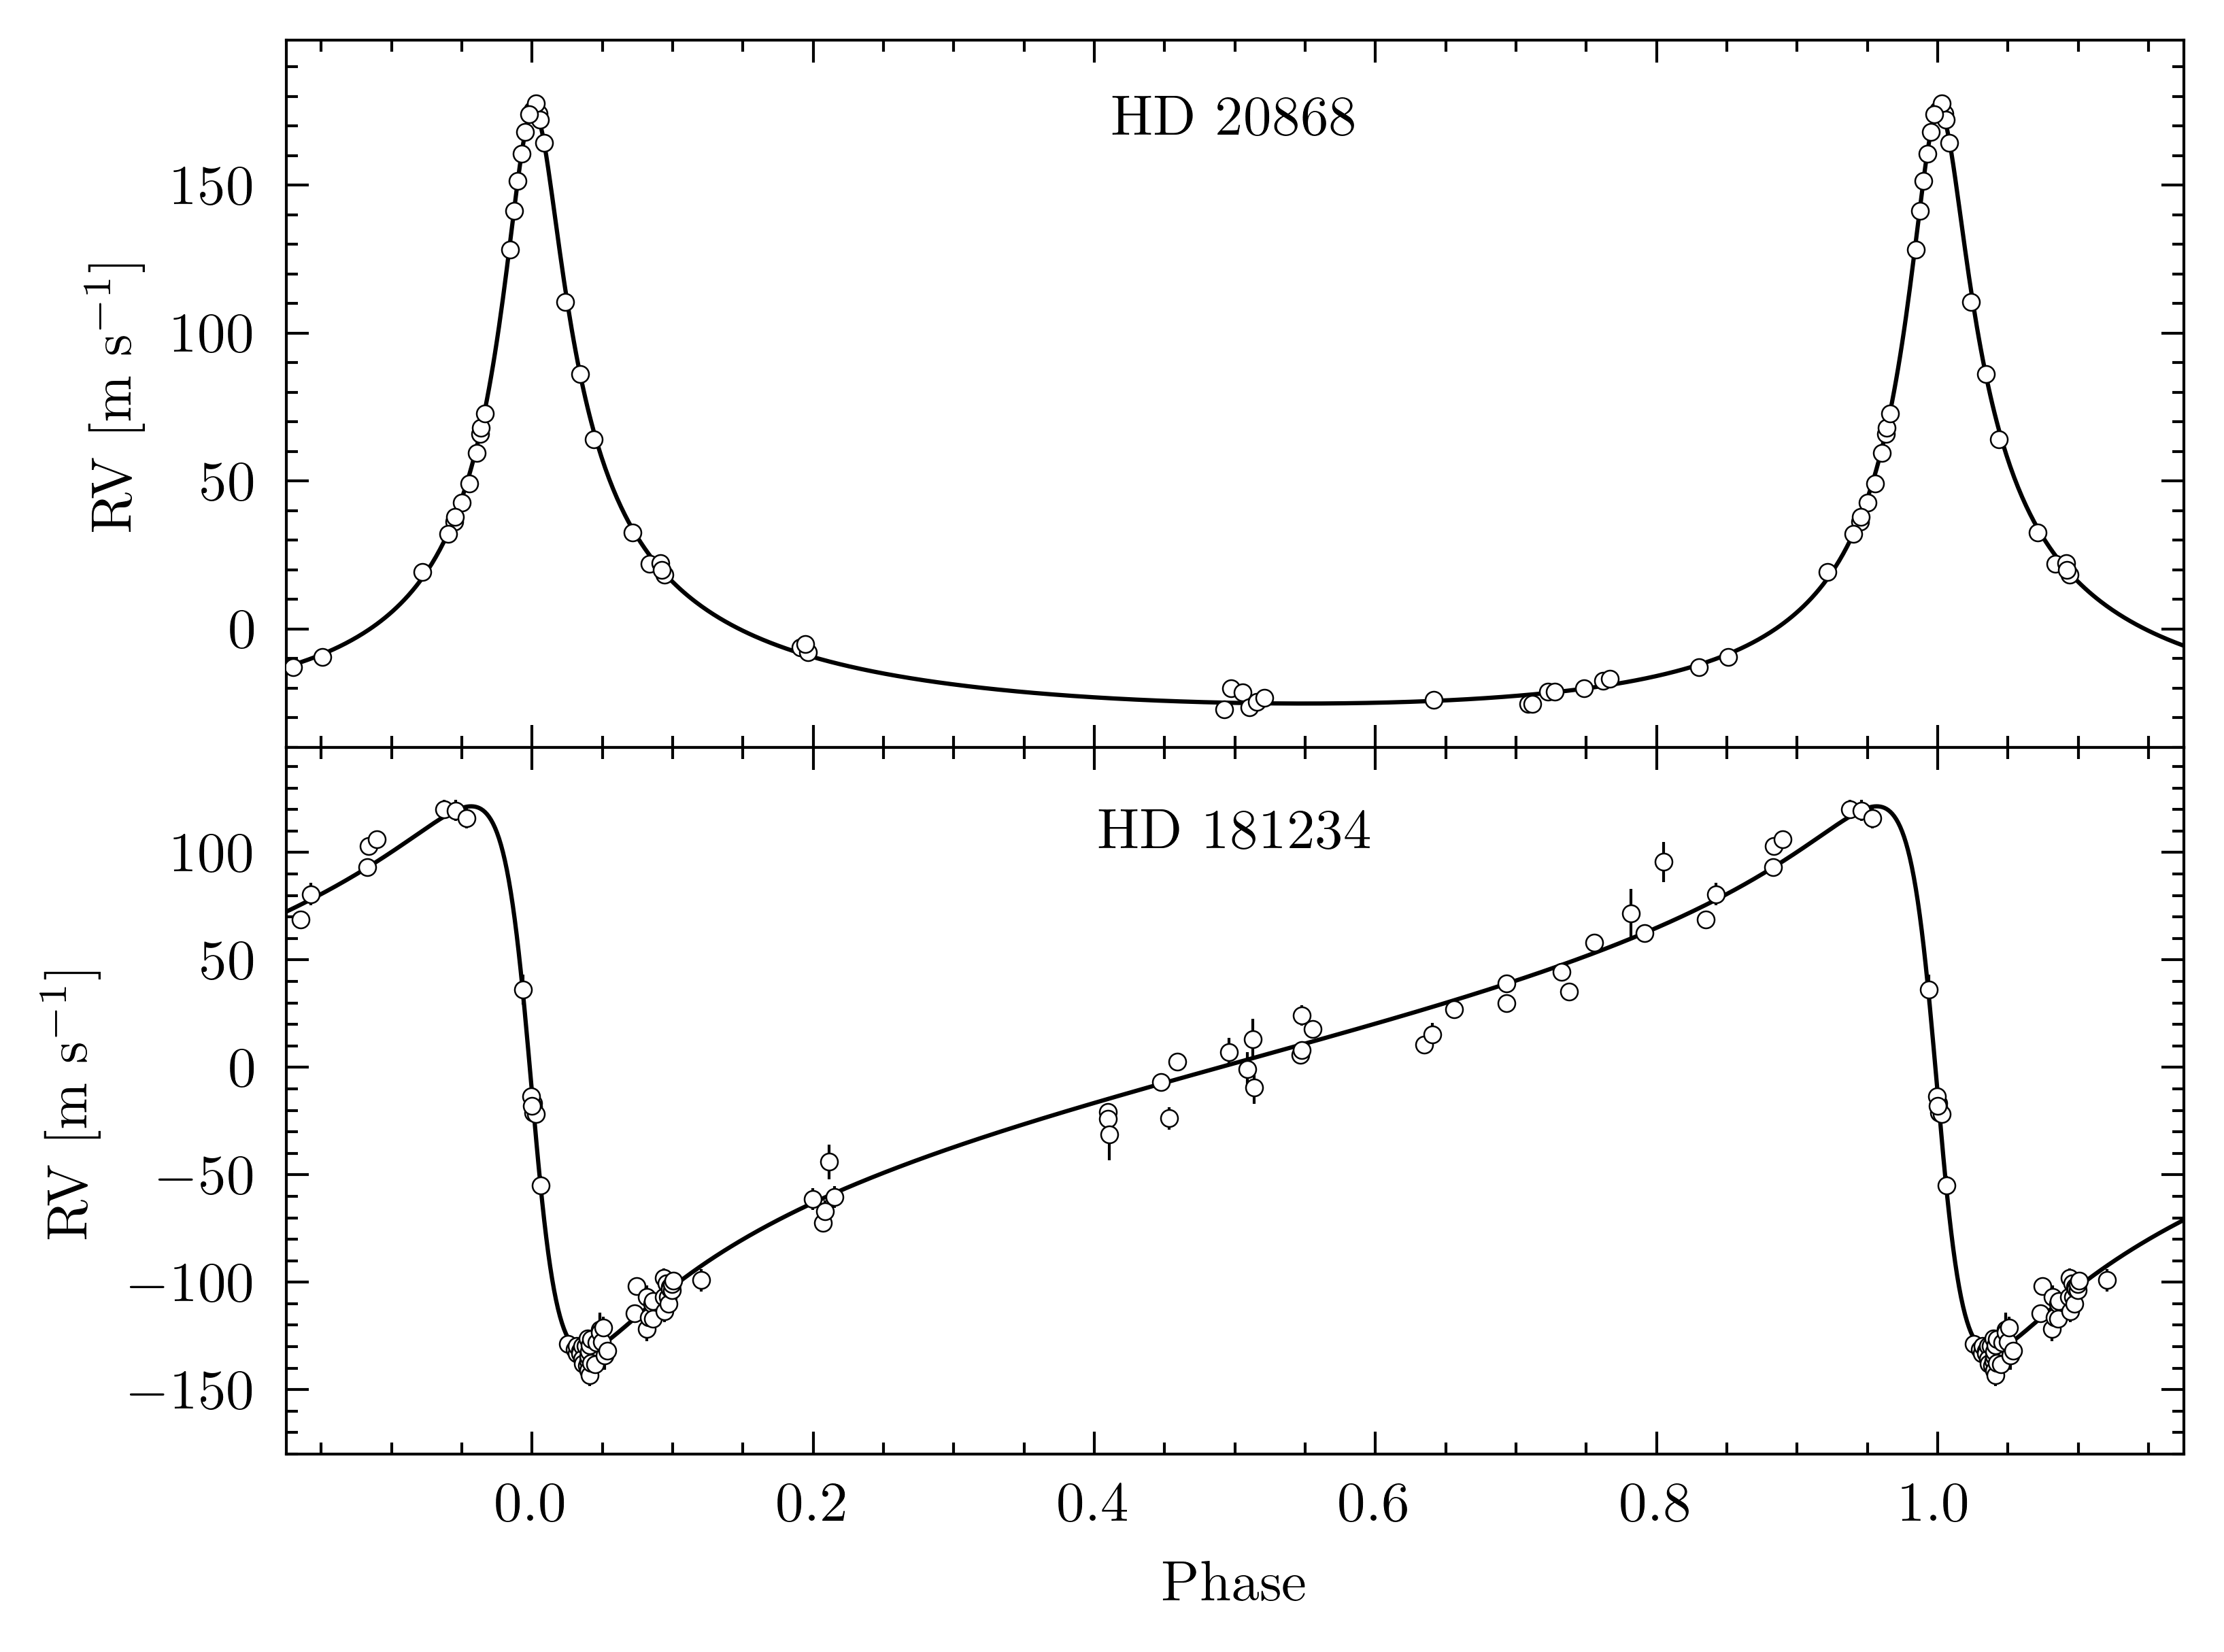

In [15]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(wInches,hInches),dpi=dpi)
fig.subplots_adjust(wspace=0, hspace=0)

# Top Panel: HD20868

ax1.tick_params('both',length=4,width=lwidth,which='major',direction='in',top='on',right='on')
ax1.tick_params('both',length=2,width=lwidth,which='minor',direction='in',top='on',right='on')

ax1.set_xlim(pMin,pMax)
ax1.xaxis.set_major_locator(MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(MultipleLocator(0.05))
ax1.set_xticklabels([])

ax1.set_ylim(rvMin1,rvMax1)
ax1.yaxis.set_major_locator(MultipleLocator(50))
ax1.yaxis.set_minor_locator(MultipleLocator(10))
ax1.set_ylabel(r'RV [m s$^{-1}$]',fontsize=axisFontSize)

# extend phase-folding beyond 0..1

ax1.errorbar(phase1+1,RV1,xerr=None,yerr=eRV1,fmt='o',ms=3,mfc='white',mec='black',mew=0.3,
            capsize=0.0,elinewidth=0.5,ecolor='black',zorder=10)

ax1.errorbar(phase1,RV1,xerr=None,yerr=eRV1,fmt='o',ms=3,mfc='white',mec='black',mew=0.3,
            capsize=0.0,elinewidth=0.5,ecolor='black',zorder=10)

ax1.errorbar(phase1-1,RV1,xerr=None,yerr=eRV1,fmt='o',ms=3,mfc='white',mec='black',mew=0.3,
            capsize=0.0,elinewidth=0.5,ecolor='black',zorder=10)

# plot the best-fit RV curve

ax1.plot(fitPhase1,fitRV1,'-',color='black',lw=0.75,zorder=8)

ax1.text(0.5,180,r'HD 20868',va='top',ha='center',fontsize=axisFontSize)

# Bottom panel: HD181234

ax2.tick_params('both',length=4,width=lwidth,which='major',direction='in',top='on',right='on')
ax2.tick_params('both',length=2,width=lwidth,which='minor',direction='in',top='on',right='on')

ax2.set_xlim(pMin,pMax)
ax2.xaxis.set_major_locator(MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax2.set_xlabel(r'Phase',fontsize=axisFontSize)

ax2.set_ylim(rvMin2,rvMax2)
ax2.yaxis.set_major_locator(MultipleLocator(50))
ax2.yaxis.set_minor_locator(MultipleLocator(10))
ax2.set_ylabel(r'RV [m s$^{-1}$]',fontsize=axisFontSize)

# extend phase-folding beyond 0..1

ax2.errorbar(phase2+1,RV2,xerr=None,yerr=eRV2,fmt='o',ms=3,mfc='white',mec='black',mew=0.3,
            capsize=0.0,elinewidth=0.5,ecolor='black',zorder=10)

ax2.errorbar(phase2,RV2,xerr=None,yerr=eRV2,fmt='o',ms=3,mfc='white',mec='black',mew=0.3,
            capsize=0.0,elinewidth=0.5,ecolor='black',zorder=10)

ax2.errorbar(phase2-1,RV2,xerr=None,yerr=eRV2,fmt='o',ms=3,mfc='white',mec='black',mew=0.3,
            capsize=0.0,elinewidth=0.5,ecolor='black',zorder=10)

# plot the best-fit RV curve

ax2.plot(fitPhase2,fitRV2,'-',color='black',lw=0.75,zorder=8)

ax2.text(0.5,120,r'HD 181234',va='top',ha='center',fontsize=axisFontSize)

plt.plot()

plt.savefig(plotFile,bbox_inches='tight',facecolor='white')